In [1]:
from opxrd import OpXRD

# ------------------------------------------------------------

smoltest_dirpath = '/home/daniel/aimat/data/opXRD/test_smol'
bigtest_dirpath = '/home/daniel/aimat/data/opXRD/test'
test_databases = OpXRD.load_project_list(root_dirpath=bigtest_dirpath)

- Loading databases from /home/daniel/aimat/data/opXRD/test
[2024-12-19 17:26:57]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/EMPA


100% (770 of 770) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-19 17:26:58]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/EMPA
[2024-12-19 17:26:58]: Successfully extracted 770 patterns from 770/770 xrd files
[2024-12-19 17:26:58]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/USC


100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-19 17:26:59]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/USC
[2024-12-19 17:26:59]: Successfully extracted 338 patterns from 338/338 xrd files
[2024-12-19 17:26:59]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/HKUST/in_house


100% (21 of 21) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[2024-12-19 17:26:59]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/HKUST/in_house
[2024-12-19 17:26:59]: Successfully extracted 21 patterns from 21/21 xrd files
[2024-12-19 17:26:59]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/HKUST/accumulated


100% (499 of 499) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-19 17:27:01]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/HKUST/accumulated
[2024-12-19 17:27:01]: Successfully extracted 499 patterns from 499/499 xrd files
[2024-12-19 17:27:01]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/CNRS


100% (210 of 210) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-19 17:27:02]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/CNRS
[2024-12-19 17:27:02]: Successfully extracted 210 patterns from 210/210 xrd files
[2024-12-19 17:27:02]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test/IKFT


100% (64 of 64) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


[2024-12-19 17:27:02]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test/IKFT
[2024-12-19 17:27:02]: Successfully extracted 64 patterns from 64/64 xrd files


---> Combined pattern plot for databaes ['a:EMPA', 'b:USC', 'c:HKUST-A', 'd:HKUST-B', 'e:CNRS', 'f:IKFT'] | No. patterns = 10

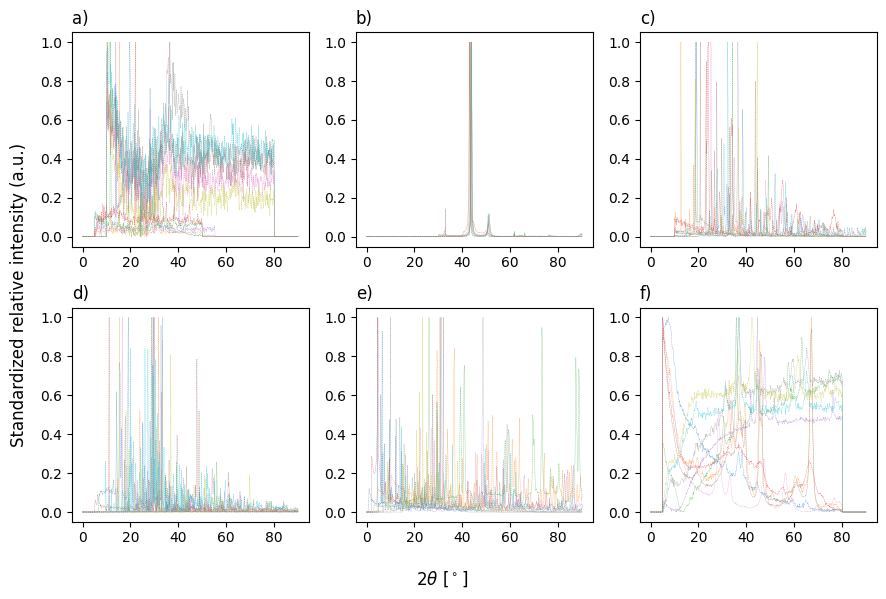

In [2]:
from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=test_databases, output_dirpath='/tmp/opxrd_analysis')
analyser.plot_in_single(limit_patterns=10)


---> Combined pattern plot for databaes ['a:EMPA', 'b:USC', 'c:HKUST-A', 'd:HKUST-B', 'e:CNRS', 'f:IKFT'] | No. patterns = 50

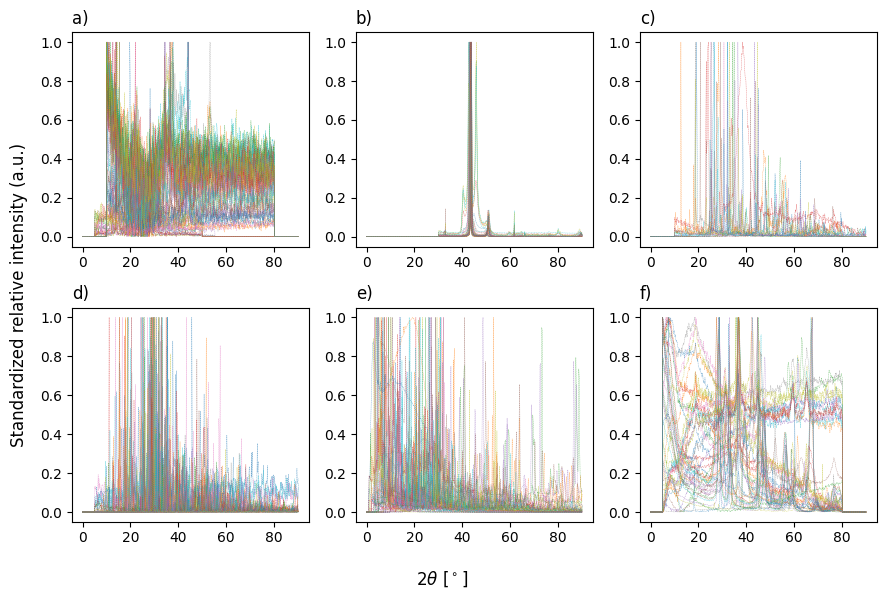

In [3]:
analyser.plot_in_single(limit_patterns=50)

---> Combined pattern plot for databaes ['a:EMPA', 'b:USC', 'c:HKUST-A', 'd:HKUST-B', 'e:CNRS', 'f:IKFT'] | No. patterns = 1000

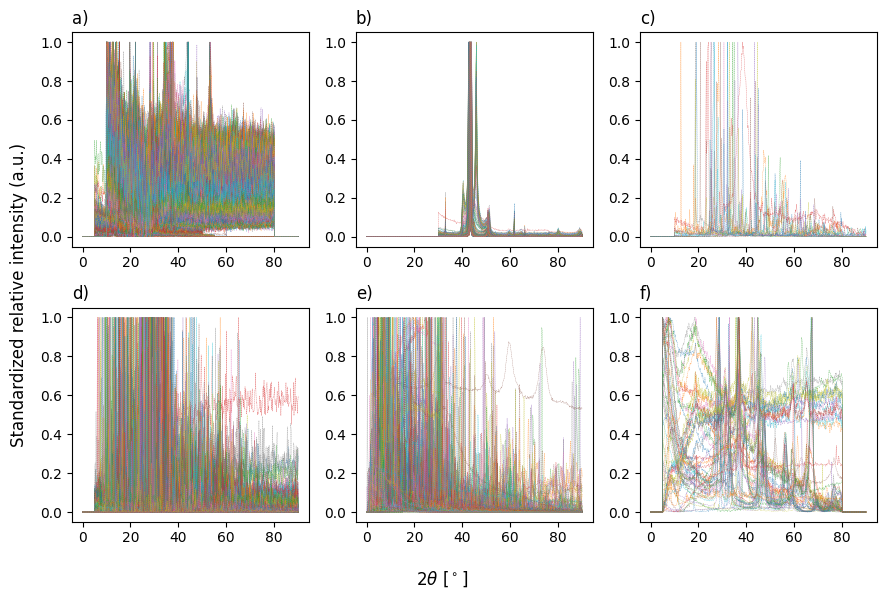

In [4]:
analyser.plot_in_single(limit_patterns=1000)

Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for EMPA | No. patterns = 770
[Debug]: Performing PCA for USC | No. patterns = 338
[Debug]: Performing PCA for HKUST-A | No. patterns = 21
[Debug]: Performing PCA for HKUST-B | No. patterns = 499
[Debug]: Performing PCA for CNRS | No. patterns = 210
[Debug]: Performing PCA for IKFT | No. patterns = 64


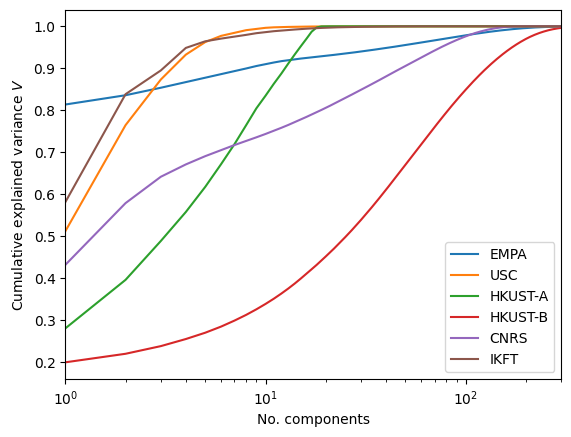

In [5]:
analyser.plot_effective_components()

---> Histogram of general information

/home/daniel/aimat/xrdpattern/xrdpattern/pattern/visualization.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


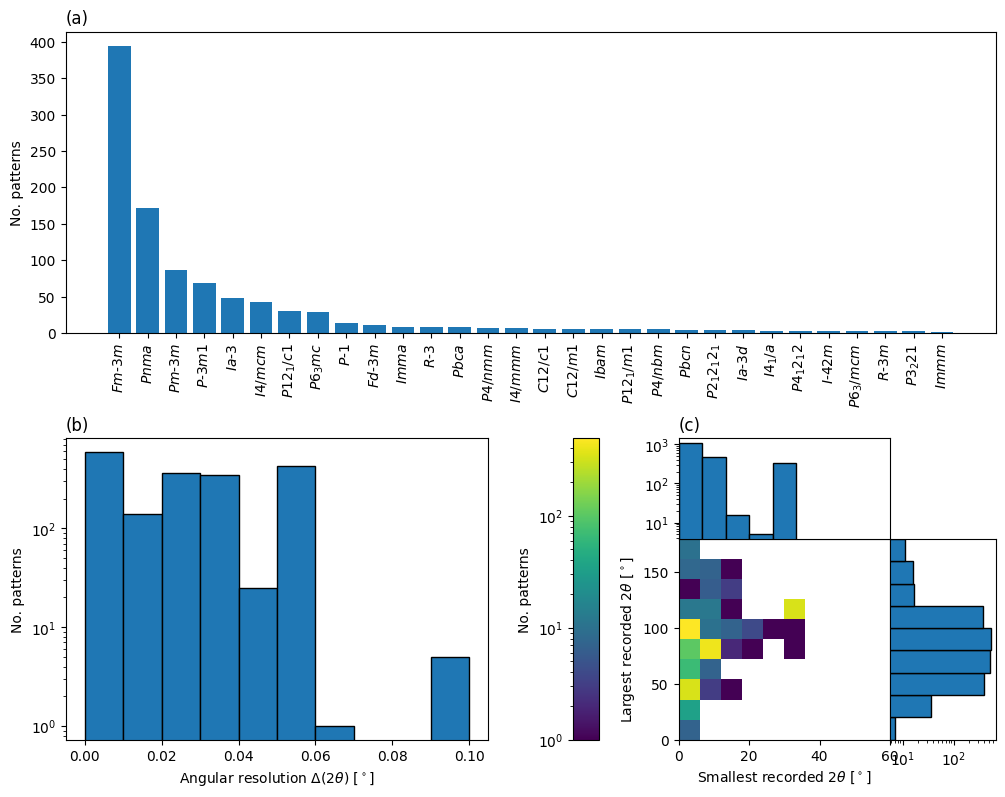

In [6]:
analyser.plot_histogram()

In [7]:
analyser.print_total_counts()

---> Total pattern counts in opXRD

Total number of patterns = 1902
Number of labeled patterns = 1836
